```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture15-PartialDifferentialEquations.pdf)
```

# Boundary value problems

## Laplace's equation

```{figure} fig9-2.png
:width: 400px
:align: center
:name: fig-fd
```
<center>
    Source: M. Newman, Computational Physics
</center>

Boundary value problems typically deal with static solutions (no time variable)

Consider Laplace's equation (no external charges) in two dimensions

$$
\frac{\partial^2 \phi(x,y)}{\partial x^2}
+
\frac{\partial^2 \phi(x,y)}{\partial y^2}
=
0.
$$



Boundary conditions: one of the walls has voltage $V$ applied to it, the rest are grounded:
\begin{align*}
\phi(x,L) & = V, \\
\phi(x,0) & = 0, \\
\phi(0,y) & = 0, \\
\phi(L,y) & = 0.
\end{align*}

Let us apply finite difference method. 
Discretize the box into a grid in steps $a = L / M$ in each direction.
Approximate the derivatives by central differences:
\begin{align*}
\frac{\partial^2 \phi(x,y)}{\partial x^2} & = \frac{\phi(x+a,y) - 2\phi(x,y) + \phi(x-a,y)}{a^2}, \\
\frac{\partial^2 \phi(x,y)}{\partial y^2} & = \frac{\phi(x,y+a) - 2\phi(x,y) + \phi(x,y-a)}{a^2}.
\end{align*}

Laplace's equation becomes

$$
\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y) = 0.
$$

In principle, this is a system of $N \sim M^2$ linear equations that can be solved exactly.
The general method will however require $O(N^3) = O(M^6)$ operations which becomes unfeasible already for $M \sim 100$ or so.

## Jacobi (relaxation) method

Start with some initial guess $\phi_0(x,y)$. The next iteration is given by

$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$

for all points inside the box. Preserve the boundary conditions at each iteration:
\begin{align*}
\phi_{n+1}(x,L) & = V, \\
\phi_{n+1}(x,0) & = 0, \\
\phi_{n+1}(0,y) & = 0, \\
\phi_{n+1}(L,y) & = 0.
\end{align*}

This is the Jacobi (or relaxation) method, and for Laplace's equation it is always converges. Let us implement it in Python:

In [1]:
import numpy as np

# Single iteration of the Jacobi method
# The new field is written into phinew
def iteration_jacobi(phinew, phi):
    M = len(phi) - 1
    
    # Boundary conditions
    phinew[0,:] = phi[0,:]
    phinew[M,:] = phi[M,:]
    phinew[:,0] = phi[:,0]
    phinew[:,M] = phi[:,M]
    
    for i in range(1,M):
        for j in range(1,M):
            phinew[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4
                
    delta = np.max(abs(phi-phinew))
    
    return delta

def jacobi_solve(phi0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = iteration_jacobi(phi, phi0)
        phi0, phi = phi, phi0
        
        if (delta <= target_accuracy):
            print("Jacobi method converged in " + str(i+1) + " iterations")
            return phi0
        
    print("Jacobi method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Jacobi method converged in 1909 iterations


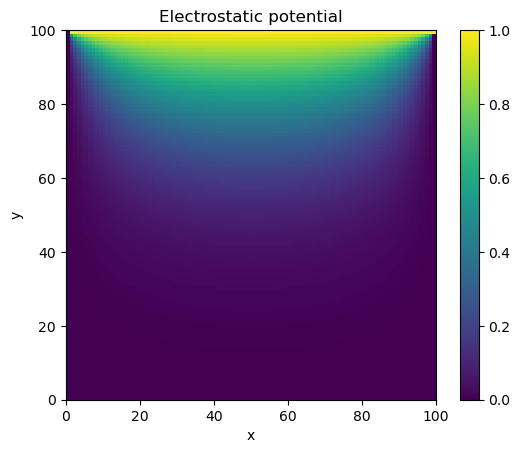

CPU times: user 8.57 s, sys: 128 ms, total: 8.7 s
Wall time: 8.64 s


In [2]:
%%time
# Measure execution time

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Initialize with zeros
phi = np.zeros([M+1,M+1],float)
# Boundary condition
phi[0,:] = V
phi[:,0] = 0

phi = jacobi_solve(phi, target, 10000)

# Plot
import matplotlib.pyplot as plt

plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

## Gauss-Seidel method with overrelaxation

The base Jacobi method corresponds to an iteration

$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$

This requires to have two arrays independently.
In Gauss-Seidel method one uses the already computed values of $\phi_{n+1}$ where availabl instead.
The method thus corresponds to

$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4}
$$

Another modification is the use of overrelaxation.

The base Jacobi method is a type of relaxation method

$$
\phi_{n+1}(x,y) = \phi_n(x,y) + \Delta_n \phi(x,y).
$$

A way to speed-up calculation is to overrelaxate the solution a bit

$$
\phi_{n+1}(x,y) = \phi_n(x,y) + (1+\omega) \Delta_n \phi(x,y),
$$

where $\omega > 0$.

This implies the following iterative procedure

$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4} - \omega \, \phi_n(x,y).
$$

This is unstable for $\omega > 0$. However, applied to Gauss-Seidel method, this corresponds to

$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4} - \omega \, \phi_n(x,y),
$$

and provides generally stable solution for $\omega < 1$. 

In [ ]:
import numpy as np

# Single iteration of the Gauss-Seidel method
# The new field is written into phi directly
# omega >= 0 is the overrelaxation parameter
def gaussseidel_iteration(phi, omega = 0):
    M = len(phi) - 1
    
    delta = 0.
    
    # New iteration
    for i in range(1,M):
        for j in range(1,M):
            phiold = phi[i,j]
            phi[i,j] = (1. + omega) * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 - omega * phi[i,j]
            delta = np.maximum(delta, abs(phiold - phi[i,j]))
    
    return delta

def gaussseidel_solve(phi0, omega = 0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = gaussseidel_iteration(phi, omega)
        
        if (delta <= target_accuracy):
            print("Gauss-Seidel method converged in " + str(i+1) + " iterations")
            return phi
        
    print("Gauss-Seidel method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Let us check the performance of the Gauss-Seidel method with overrelaxation.

Jacobi method converged in 137 iterations


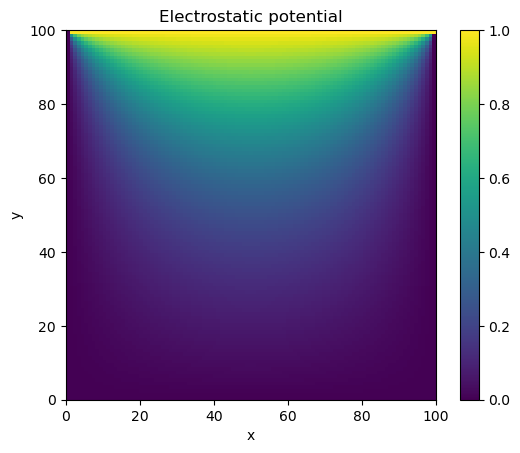

CPU times: user 1.97 s, sys: 46.2 ms, total: 2.01 s
Wall time: 1.95 s


In [7]:
%%time

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Initialize with zeros
phi = np.zeros([M+1,M+1],float)
# Boundary condition
phi[0,:] = V
phi[:,0] = 0


omega = 0.93
phi = gaussseidel_solve(phi, omega, target, 1000)

# Plot
plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()